In [1]:
# https://www.kaggle.com/datasets/joyshil0599/abilify-oral-reviews-dataset

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import tensorflow as tf

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
nltk.download('wordnet')
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/co

In [4]:
corpus = pd.read_csv('/kaggle/input/abilify-oral-reviews-dataset/abilify_ora_effected_peple_reviewl.csv', encoding_errors='replace') # use replacement character for characters not in UTF-8
corpus.head(5)

,Time of Meditation,Suspect name,Age,Gender,Suspect Status,Date,Condition,overall-rating,description-text
0,2 to less than 5 years,Barbara,65-74,Female,Patient,2/13/2023,Bipolar Disorder in Remission,5.0,I've taken Abilify to augment bupropion for Bi...
1,1 to 6 months,Matt,35-44,Male,Patient,2/9/2023,Schizophrenia,2.0,Worked for 3 months. Waste of time. You think ...
2,1 to 6 months,Alex Adams,25-34,Male,Patient,1/5/2023,Schizophrenia,2.3,Worked really well for like 2 months then I go...
3,1 to less than 2 years,Jill,35-44,Female,Patient,12/28/2022,Additional Medications to Treat Depression,1.0,This is the worst drug on the market. It cause...
4,1 to 6 months,Anonymous,45-54,Female,Patient,12/7/2022,Additional Medications to Treat Depression,2.0,I was prescribed as a child at 15 years old. I...


In [5]:
corpus = corpus[['overall-rating', 'description-text']]
print(len(corpus))
corpus.head(5)

1835


,overall-rating,description-text
0,5.0,I've taken Abilify to augment bupropion for Bi...
1,2.0,Worked for 3 months. Waste of time. You think ...
2,2.3,Worked really well for like 2 months then I go...
3,1.0,This is the worst drug on the market. It cause...
4,2.0,I was prescribed as a child at 15 years old. I...


In [6]:
corpus = corpus.dropna(axis=0)
print(len(corpus))

1540


/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


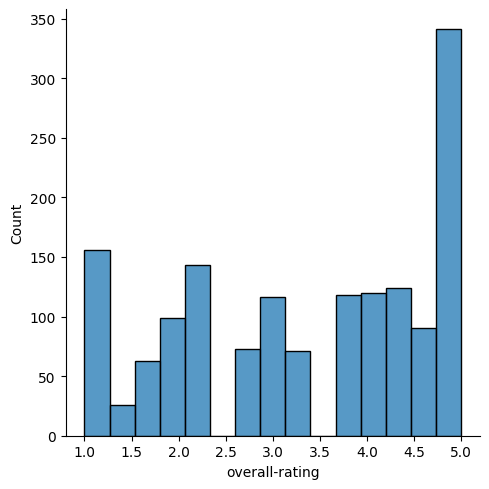

In [7]:
# fix histogram ticks
sns.displot(corpus, x='overall-rating', bins=15)

<Axes: xlabel='rating_rounded', ylabel='count'>

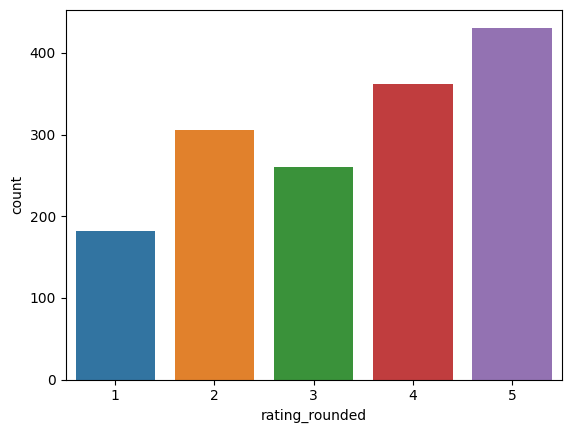

In [8]:
corpus['rating_rounded'] = corpus['overall-rating'].round().astype(int)
sns.countplot(corpus, x='rating_rounded')

In [9]:
# https://geeksforgeeks.org/python-word-embedding-using-word2vec/
# https://spotintelligence.com/2022/12/21/nltk-preprocessing-pipeline/

In [10]:
# make into sklearn pipeline

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string

stopwords = nltk.corpus.stopwords.words('english')
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    tokens = word_tokenize(text)
    tokens_lower = [token.lower() for token in tokens]
    tokens_no_punct = [token for token in tokens_lower if token not in string.punctuation]
    tokens_no_stopwords = [token for token in tokens_no_punct if token not in stopwords]
    tokens_lemmatized = [lemmatizer.lemmatize(token) for token in tokens_no_stopwords]
    sentence = ' '.join(tokens_lemmatized)
    return sentence

In [11]:
corpus['text_preprocessed'] = corpus['description-text'].apply(preprocess_text)
corpus['text_preprocessed'].head(5)

0    've taken abilify augment bupropion bipolar di...
1    worked 3 month waste time think better 's like...
2    worked really well like 2 month got restlessne...
3    worst drug market caused gain 50 pound develop...
4    prescribed child 15 year old caused muscle spa...
Name: text_preprocessed, dtype: object

In [12]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

MAX_SEQUENCE_LENGTH = 200

tokenizer = Tokenizer(oov_token='<OOV>', num_words=20000)

sentences = corpus['text_preprocessed']

# generate word indexes
tokenizer.fit_on_texts(sentences)

# generate sequences and apply padding
sequences = tokenizer.texts_to_sequences(sentences)
sequences_padded = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post')

In [13]:
words = [x.split() for x in sentences]

In [14]:
from gensim.models import Word2Vec

EMBEDDING_DIM = 200
WINDOW = 2

w2v_model = Word2Vec(words, min_count=1, vector_size=EMBEDDING_DIM, window=WINDOW)

In [15]:
# https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html

In [16]:
word_index = tokenizer.word_index
word_list = sorted(word_index.items(), key=lambda x:x[1])
word_list = [x[0] for x in word_list]

embedding_matrix = np.vstack([np.zeros([1, EMBEDDING_DIM]),
                             np.array([w2v_model.wv[word] if word in w2v_model.wv else np.zeros(EMBEDDING_DIM) for word in word_list])])

In [17]:
from tensorflow.keras.layers import Embedding

embedding_layer = Embedding(len(word_index)+1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

In [18]:
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras import Model

sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
x = Conv1D(128, 3, activation='relu')(embedded_sequences)
x = Conv1D(64, 3, activation='relu')(x)
x = Conv1D(64, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Dropout(0.2)(x)
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
preds = Dense(5, activation='softmax')(x)

model = Model(sequence_input, preds)
opt = tf.keras.optimizers.Adam(learning_rate=1e-6)
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=opt,
              metrics=['acc'])

In [19]:
from sklearn.utils import class_weight

X_train = sequences_padded[:1400]
X_test = sequences_padded[1400:]

y_train = corpus['rating_rounded'][:1400] - 1
y_test = corpus['rating_rounded'][1400:] - 1

class_weights = class_weight.compute_class_weight('balanced', classes=[0, 1, 2, 3, 4], y=y_train)
class_weights = dict(enumerate(class_weights))

model.fit(X_train, y_train, epochs=20, batch_size=32, class_weight=class_weights)

Epoch 1/20
44/44 [==============================] - 16s 19ms/step - loss: 1.6101 - acc: 0.2229
Epoch 2/20
44/44 [==============================] - 0s 4ms/step - loss: 1.6104 - acc: 0.2229
Epoch 3/20
44/44 [==============================] - 0s 5ms/step - loss: 1.6098 - acc: 0.2257
Epoch 4/20
44/44 [==============================] - 0s 4ms/step - loss: 1.6101 - acc: 0.2107
Epoch 5/20
44/44 [==============================] - 0s 4ms/step - loss: 1.6098 - acc: 0.2307
Epoch 6/20
44/44 [==============================] - 0s 4ms/step - loss: 1.6102 - acc: 0.2107
Epoch 7/20
44/44 [==============================] - 0s 4ms/step - loss: 1.6095 - acc: 0.2286
Epoch 8/20
44/44 [==============================] - 0s 4ms/step - loss: 1.6100 - acc: 0.2200
Epoch 9/20
44/44 [==============================] - 0s 4ms/step - loss: 1.6096 - acc: 0.2350
Epoch 10/20
44/44 [==============================] - 0s 4ms/step - loss: 1.6102 - acc: 0.2229
Epoch 11/20
44/44 [==============================] - 0s 4ms/step - 

In [20]:
y_pred = model.predict(X_test)
y_pred_label = [np.argmax(y) for y in y_pred]

5/5 [==============================] - 0s 53ms/step


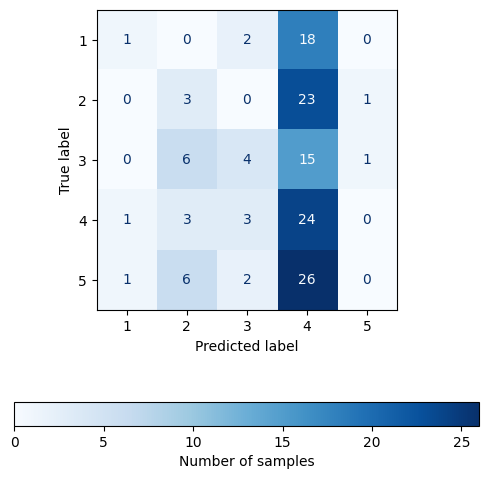

In [21]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
cm = confusion_matrix(y_test, y_pred_label)
cm_plot = ConfusionMatrixDisplay(cm, display_labels=[1, 2, 3, 4, 5])
cm_plot.plot(cmap='Blues', ax=ax)
im = cm_plot.im_
im.colorbar.remove()
plt.colorbar(im, orientation='horizontal', pad=0.2, label='Number of samples')

plt.title('');